In [1]:
from keras.layers.preprocessing.normalization import Normalization
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import MobileNetV2, VGG19, DenseNet121, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras import layers

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import seaborn as sns
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install imutils

In [4]:
from imutils import paths

In [5]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/Skripsi/Dataset Terumbu Karang/Dataset/Data Warna/data_warna fix")))

# random shuffle
random.seed(42)
random.shuffle(imagePaths)

data = []
labels = []
image_dims = (224, 224, 3)

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_dims[1], image_dims[0]))
    image = img_to_array(image)
    data.append(image)
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("{} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))

520 images (611.52MB)


In [6]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [7]:
data = np.array(data)
label = np.array(labels)
print(data.shape)

(520, 224, 224, 3)


In [8]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# total 3 labels
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

class labels:
1. Bleached
2. Healthy
3. Partially Bleached


In [9]:
densenet = DenseNet169(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

In [10]:
bs = 8
lr = 0.001
size = (224, 224)
shape = (224,224, 3)
epochs = 30
class_number = 3

In [11]:

def DenseNet_model(learning_rate, input_shape,class_number):
    densenet = DenseNet169(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape)

    for layer in densenet.layers[:-4]:
        layer.trainable = False

    model = Sequential()
    model.add(densenet)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))

    model.add(Dropout(0.5))
    model.add(layers.Dense(class_number, activation='softmax'))

    return model


In [12]:
model = DenseNet_model(lr,shape,class_number)
model.compile(loss= "categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1664)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 14976)             0         
                                                                 
 dense (Dense)               (None, 512)               7668224   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                        

In [14]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20)

In [15]:
print("[INFO] training ...")
H = model.fit(aug.flow(trainX, trainY, batch_size=bs),steps_per_epoch=len(trainX) // bs,	validation_data=(testX, testY),	validation_steps=len(testX) // bs,	epochs=epochs)

[INFO] training ...
Epoch 1/30
52/52 [==============================] - 28s 193ms/step - loss: 5.8818 - accuracy: 0.4423 - val_loss: 1.5568 - val_accuracy: 0.5865
Epoch 2/30
52/52 [==============================] - 6s 112ms/step - loss: 1.9099 - accuracy: 0.5264 - val_loss: 0.8370 - val_accuracy: 0.5865
Epoch 3/30
52/52 [==============================] - 8s 147ms/step - loss: 0.8287 - accuracy: 0.6298 - val_loss: 0.7435 - val_accuracy: 0.6635
Epoch 4/30
52/52 [==============================] - 6s 113ms/step - loss: 0.7779 - accuracy: 0.6707 - val_loss: 0.7307 - val_accuracy: 0.6731
Epoch 5/30
52/52 [==============================] - 8s 148ms/step - loss: 0.7421 - accuracy: 0.6683 - val_loss: 0.7560 - val_accuracy: 0.6250
Epoch 6/30
52/52 [==============================] - 6s 115ms/step - loss: 0.7524 - accuracy: 0.6635 - val_loss: 0.8371 - val_accuracy: 0.6442
Epoch 7/30
52/52 [==============================] - 8s 148ms/step - loss: 0.8238 - accuracy: 0.6274 - val_loss: 0.7277 - val_ac

In [16]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=bs)
y_predict =predIdxs
# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification reportD
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=mlb.classes_))

[INFO] evaluating network...
13/13 [==============================] - 3s 44ms/step
                    precision    recall  f1-score   support

          Bleached       0.88      0.81      0.84        26
           Healthy       0.83      0.56      0.67        27
Partially Bleached       0.73      0.88      0.80        51

          accuracy                           0.78       104
         macro avg       0.81      0.75      0.77       104
      weighted avg       0.79      0.78      0.77       104



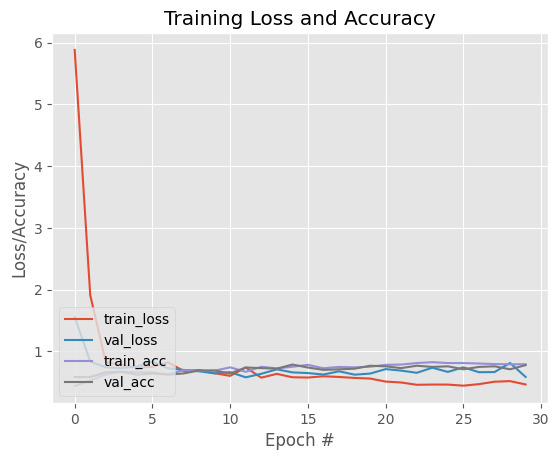

In [17]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

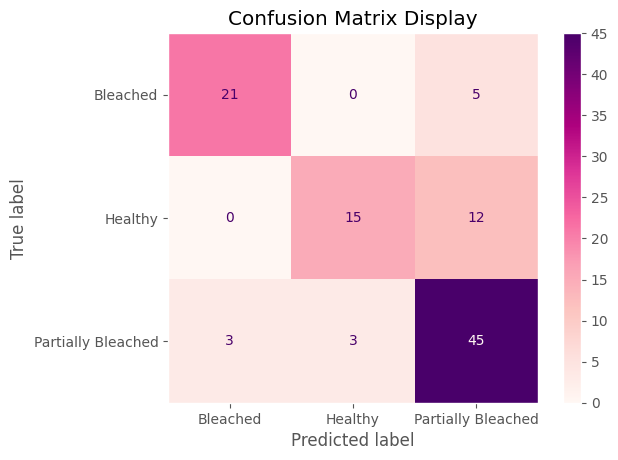

In [18]:
# Pembuatan Confusion Matrix Display
cmd= metrics.confusion_matrix(testY.argmax(axis=1), np.argmax(y_predict, axis=1))
display_label = ['Bleached','Healthy','Partially Bleached']

cm_lr= ConfusionMatrixDisplay(cmd, display_labels = display_label )
cm_lr.plot(cmap=plt.cm.RdPu)
plt.grid(False)
plt.title("Confusion Matrix Display")

plt.show()

In [21]:
# model.save('/content/drive/MyDrive/Skripsi/Program CNN/DenseNet/Saved Model/new_densenet_30_warna_2_3CAT.h5')

In [22]:
# with open('/content/drive/MyDrive/Skripsi/Program CNN/DenseNet/Saved History Model/new_densenet169_H_30_2_3CAT', 'wb') as file_pi:
    # pickle.dump(H.history, file_pi)